# RFM-анализ

## Выбор и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import datetime as dt

RFM-анализ - сегментация клиентской базы на основе трёх параметров: *Recency*, *Frequency* и *Monetary value*. На основе этих значений клиентская база делится на сегменты. В нашем случае их будет 27. Получить нужную информацию мы можем из файла `fourth_case_demographics.csv`.

In [2]:
dataframe = pd.read_csv("Data/Production/fourth_case_demographics.csv")
dataframe.head()

,Unnamed: 0,id,gender,birthday,age,agreement_status,renewal_agreement_status,sequence_agreement_number,expense_all,expense_in_contract,visits_on_contract,saledate,enddate
0,0,10ca99cf-d74c-4424,Мужской,1974-12-15T00:00:00,48,Активен,Не продлено,2,29655.72,2655.72,10,2022-12-31T19:42:35,2024-03-30T23:59:59
1,1,ecce2112-0f09-409a,Женский,1979-10-03T00:00:00,43,Активен,Не продлено,1,7693.14,7693.14,11,2022-12-31T18:17:45,2024-02-16T23:59:59
2,2,cefeeaf5-0001-4364,Мужской,1976-03-24T00:00:00,47,Активен,Не продлено,1,6953.18,6953.18,19,2022-12-31T18:12:07,2024-01-31T23:59:59
3,3,4ae2eee8-d209-4e94,Женский,1972-01-03T00:00:00,51,Активен,Не продлено,6,78130.36,22930.36,18,2022-12-31T18:04:05,2024-02-25T23:59:59
4,4,e5f22aa5-2e12-4056,Мужской,1992-11-15T00:00:00,30,Активен,Не продлено,2,58256.36,24756.36,9,2022-12-31T17:41:21,2024-01-13T23:59:59


Из данного датасета нас, по сути, интересует всего 3 столбца - `id`, `expense_all` и `saledate`. Я выбрал именно `expense_all`, а не `expense_in_contract`, т.к. таким образом мы получим более полные данные о тратах клиента. Также столбец с нумерацией нам понадобится для посчёта *Frequency*. От остальных столбцов можно избавиться. Это и сделаем.

In [3]:
dataframe = dataframe.drop(columns=['gender', 'birthday', 'age', 'agreement_status',
                                    'renewal_agreement_status', 'sequence_agreement_number', 
                                    'expense_in_contract', 'visits_on_contract', 'enddate'], axis=1)

Переведём дату продажи контракта в формат datetime.

In [4]:
dataframe['saledate'] = pd.to_datetime(dataframe['saledate'])

Для определения Recency даты будет достаточно, время продажи не обязательно.

In [5]:
dataframe['saledate'] = dataframe['saledate'].dt.date

На всякий случай проверим данные на пропуски.

In [6]:
print(dataframe.shape)
print(dataframe.dropna().shape)

(5886, 4)
(5886, 4)


## Создание RFM-таблицы

Для определения Recency мы должны выявить дату, от которой этот параметр будет определяться. Данные у нас за 2022 год, так что можем взять за точку отсчёта 1 января 2023 года.

In [7]:
NOW = dt.date(2023, 1, 1)

Создадим RFM-таблицу.

In [8]:
rfmTable = dataframe.groupby('id').agg({'saledate': lambda x: (NOW - x.max()).days, # Recency
                                        'Unnamed: 0': lambda x: len(x),      # Frequency
                                        'expense_all': lambda x: x.max()}) # Monetary Value

rfmTable['saledate'] = rfmTable['saledate'].astype(int)
rfmTable.rename(columns={'saledate': 'recency',
                         'Unnamed: 0': 'frequency',
                         'expense_all': 'monetary_value'}, inplace=True)

Посмотрим, как выглядит наша таблица.

In [9]:
rfmTable.head()

,recency,frequency,monetary_value
id,,,
0006fabb-16a9-4209,44,2,22140.82
0015d3ed-909c-4427,59,1,87809.95
0027514d-17cd-46a7,123,1,41700.00
003ad79f-dbfc-4939,102,1,26431.88
004637b8-28fc-4769,259,1,23713.41


Проверим значения на наличие выбросов.

<Axes: >

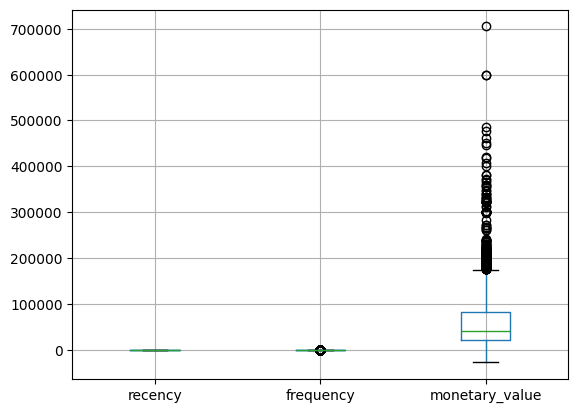

In [10]:
rfmTable.boxplot()

In [11]:
# rfmTable[rfmTable['frequency'] > 100]

In [12]:
# rfmTable[rfmTable['monetary_value'] > 500000]

Эти записи слишком сильно выбиваются из общей картины. Лучше их удалить, чтобы анализ был более точным.

In [13]:
# rfmTable = rfmTable[rfmTable['monetary_value'] < 500000]
# rfmTable = rfmTable[rfmTable['frequency'] < 100]

## Вычисление квартилей

Сегментировать клиентов мы будем именно относительно третилей. Создадим словарь, содержащий третили.

In [14]:
quartiles = rfmTable.quantile(q=[0.33, 0.66]).to_dict()
quartiles

{'recency': {0.33: 108.0, 0.66: 239.0},
 'frequency': {0.33: 1.0, 0.66: 1.0},
 'monetary_value': {0.33: 26000.0, 0.66: 62186.5}}

Видим, что с третилями у *Frequency* есть проблема. Посмотрим, насколько всё плохо.

In [15]:
rfmTable['frequency'].describe()

count    5251.000000
mean        1.120929
std         1.642310
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       117.000000
Name: frequency, dtype: float64

У **подавляющего** числа записей *frequency* равна 1. Третили, соответственно, найти не получится.

Я попробовал выравнять значения с помощью различных алгоритмов (K-децильное кодирование, Min-Max Scaling, Логарифмирование), но ни один из методов так и не дал хоть сколько-нибудь удовлетворительных результатов. Мы можем попробовать метод, который, скорее всего, статистически будет не совсем верный. Сегментирование по *frequency* мы будем выполнять не на основе третилей, а на основе задаваемых нами значений. Посмотрим, какие значения присутствуют.

In [16]:
rfmTable['frequency'].unique()

array([  2,   1, 117,   3,   4,   6,   5,   8], dtype=int64)

С помощью квартилей расставить пороги сегментов у *Frequency* тут не получится. Попробуем сделать это вручную. Расставим пороги так: разовые клиенты имеют *frequency* <= 2; редкие - <= 4; постоянные - 5 и более. Судя по данным, речь идёт о занятиях в спортивно-оздоровительном центре и в таком контексте такие пороговые значения количества контрактов в год звучат вполне реалистично.

In [17]:
quartiles['frequency'] = {0.33: 2, 0.66: 4}

## Сегментация

Создадим функции для выполнения сегментации. В нашем случае, каждый параметр будет иметь свою функцию.

In [18]:
def RClass(x, p, d): # У Recency чем меньше значение - тем для нас лучше
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else: 
        return 3

def FMClass(x,p,d): # С остальными параметрами наоборот
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else: 
        return 1

Применим эти функции к показателям чтобы сегментировать клиентскую базу.

In [19]:
rfmSegmentation = rfmTable

rfmSegmentation['RQ'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quartiles,))
rfmSegmentation['FQ'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSegmentation['MQ'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

Из сегментов по каждому из признаков соберём итоговый RFM-класс.

In [20]:
rfmSegmentation['RFMClass'] = rfmSegmentation.RQ.map(str) \
                            + rfmSegmentation.FQ.map(str) \
                            + rfmSegmentation.MQ.map(str)

Теперь можем найти нашего самого ценного клиента.

In [21]:
rfmSegmentation.sort_values('RFMClass', ascending=True)

,recency,frequency,monetary_value,RQ,FQ,MQ,RFMClass
id,,,,,,,
27487f0e-8ade-42bd,12,5,119900.00,1,1,1,111
f6509abd-5ec1-4adc,67,8,66350.00,1,1,1,111
036c2615-89f2-4094,1,117,166607.64,1,1,1,111
d67cfcde-da4e-46a9,29,5,117500.00,1,1,1,111
1be7c783-affc-40d3,42,6,30219.49,1,1,2,112
...,...,...,...,...,...,...,...
b113b48b-de56-46ba,277,1,21800.00,3,3,3,333
b0ee88e7-f6c7-4d79,299,1,0.00,3,3,3,333
b0ea07ec-27b7-49c5,329,1,3641.00,3,3,3,333


In [22]:
rfmSegmentation['RFMClass'].unique()

array(['133', '131', '232', '132', '333', '332', '231', '233', '331',
       '111', '123', '321', '122', '223', '121', '112', '323', '221',
       '222', '322', '213', '113', '212'], dtype=object)

## Визуализация данных

Для составления круговой дииаграммы создадим дополнительный датафрейм.

In [23]:
class_counts = rfmSegmentation["RFMClass"].value_counts().to_frame(name="count")
class_counts["percentage"] = class_counts["count"] / rfmSegmentation.shape[0] * 100
class_counts.index = class_counts.index.astype("str")
labels = ["{0} ({1:.3f}%)".format(label, percentage) for label, percentage in zip(class_counts.index, class_counts["percentage"])]

Выведем круговую диаграмму.

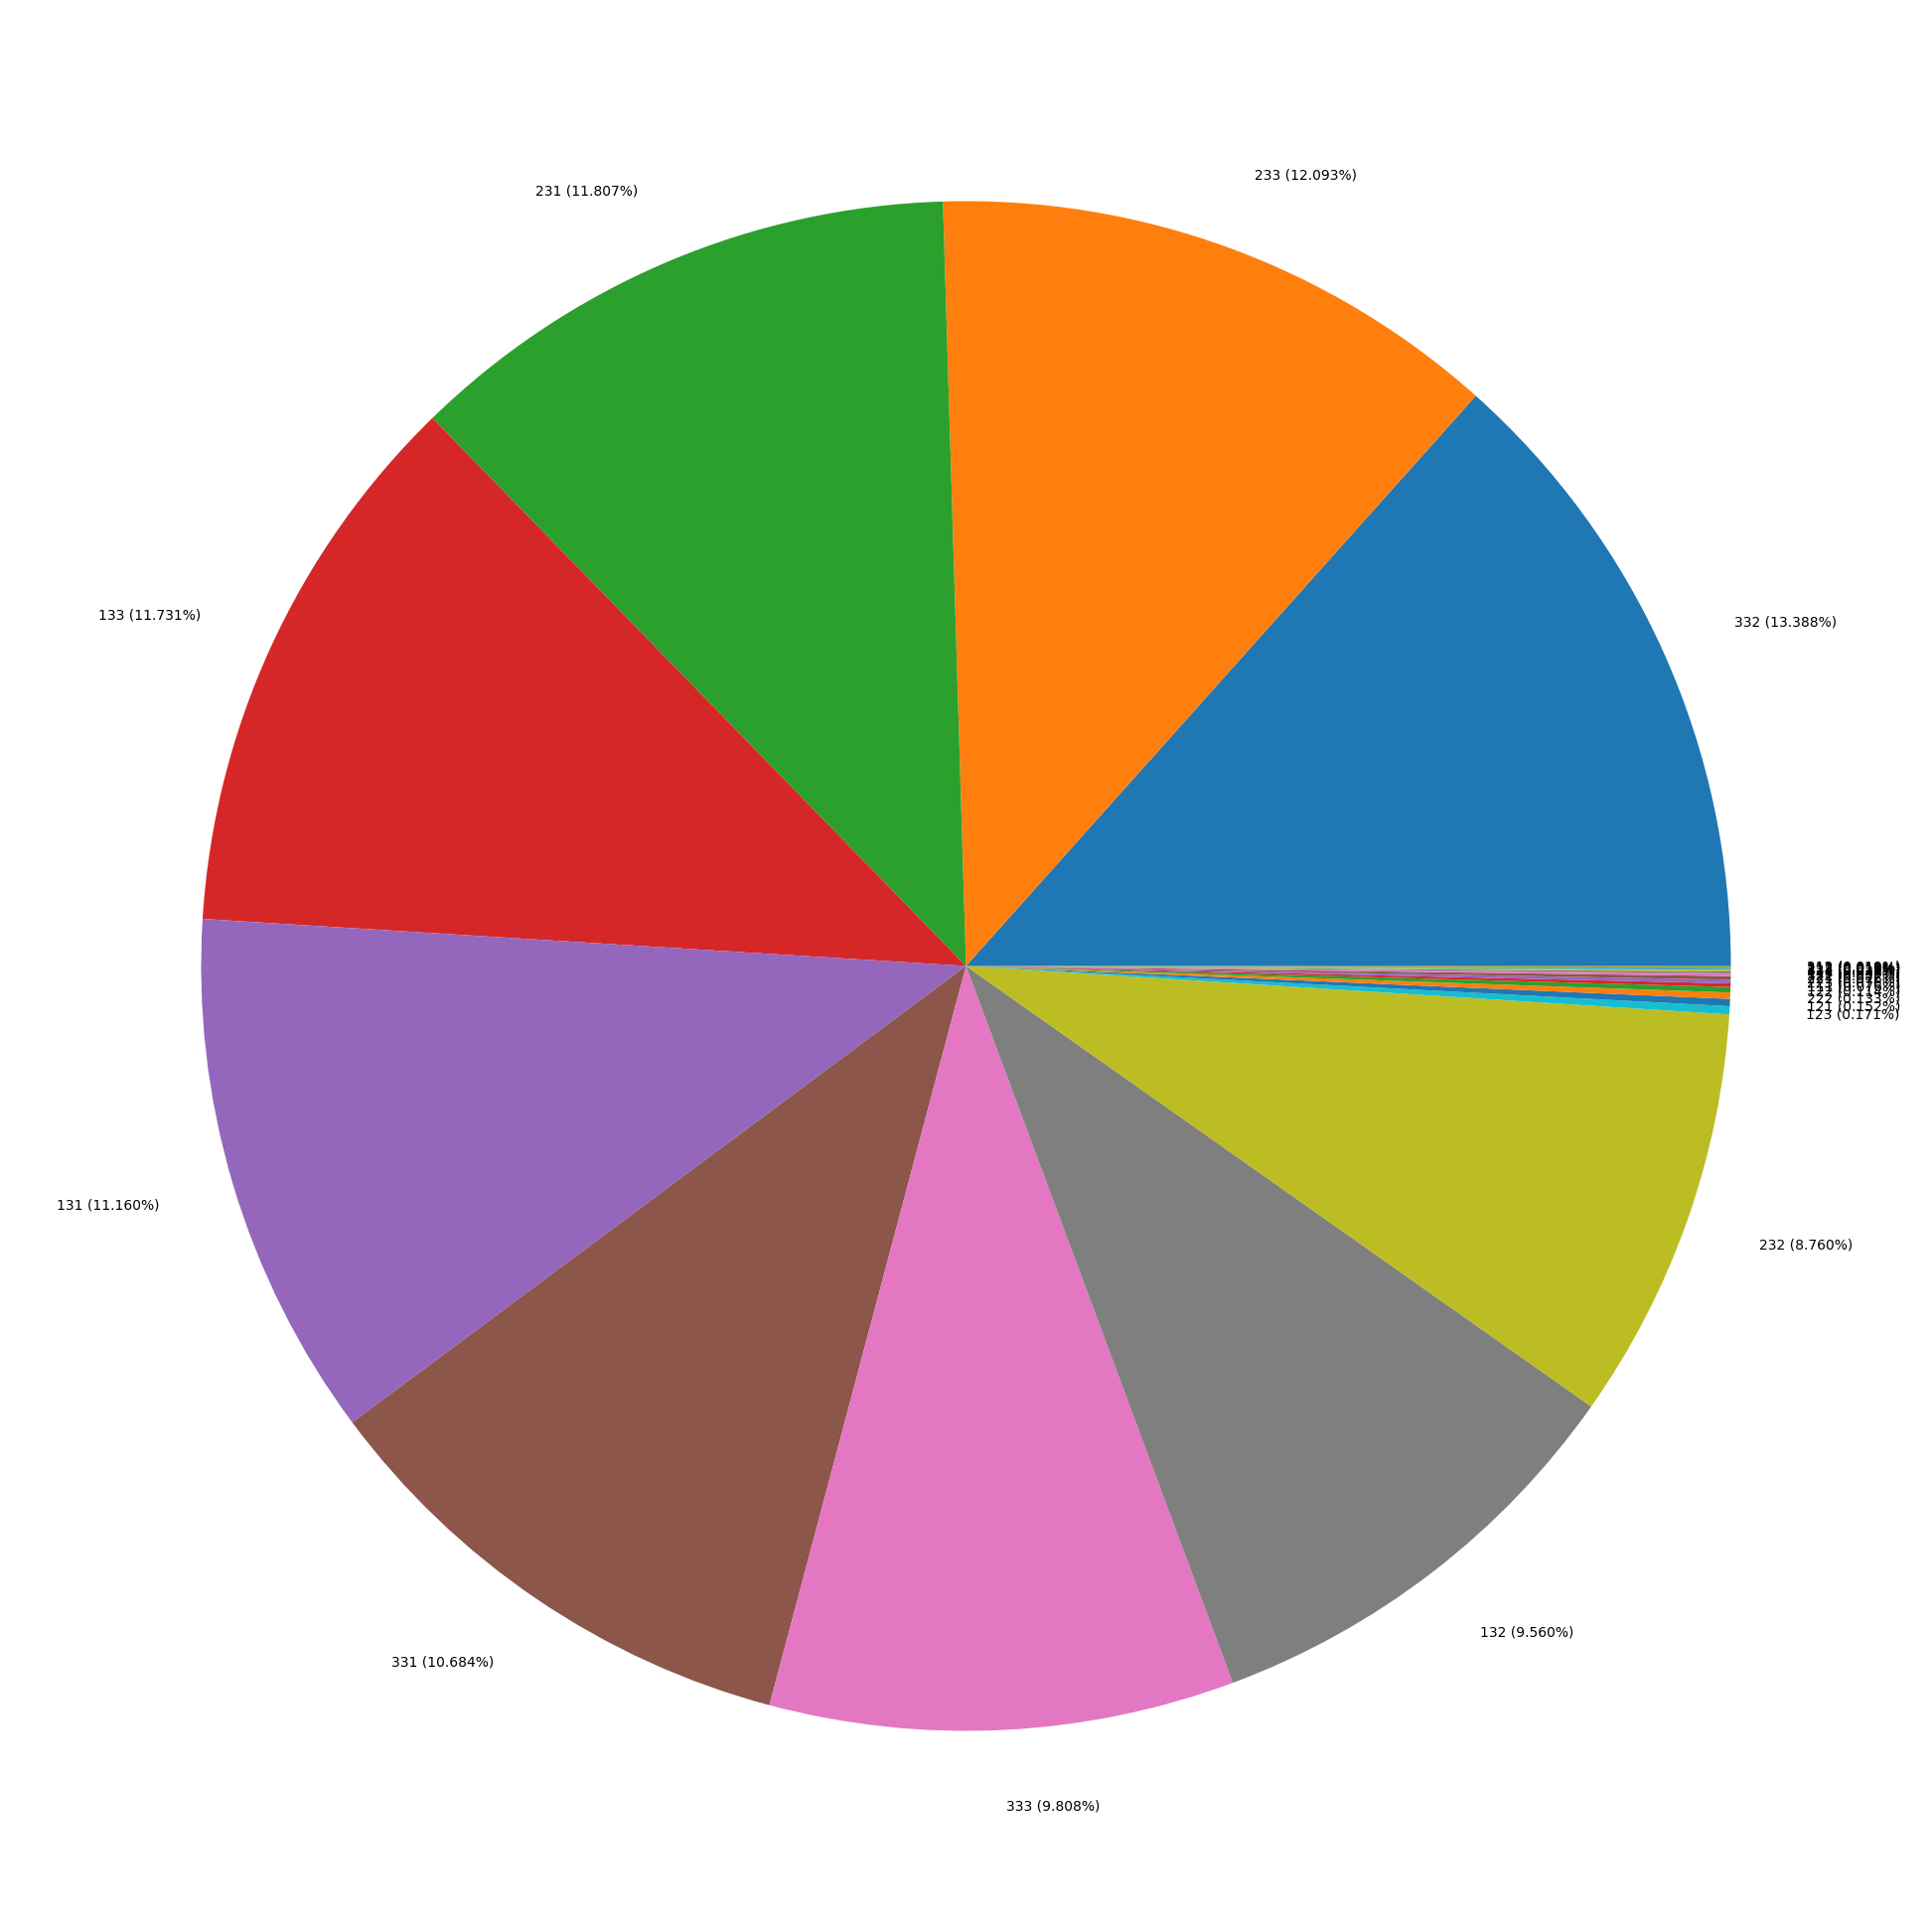

In [24]:
plt.figure(figsize=(25, 25))
plt.pie(class_counts["percentage"],labels=labels)
plt.show()